# Eucalc
**Authors**: V. Lebovici, H. Passe

In this notebook, we provide a detailed introduction to our ```C++``` / ```Python``` library ```Eucalc```, which implements algorithms to compute Euler characteristic transform, Radon transform and hybrid transforms on cubical complexes. For more details, see [our paper](https://arxiv.org/abs/2405.02256).

**NB:** We try to provide enough details to understand our implementation. For a more straightforward example, see ```minimal_example.ipynb```.

---

**Preliminary:** adding the right folder to path.

In [140]:
import sys
sys.path.append('..')

### Weighted cubical complexes
A *cube* of $\mathbb{R}^n$ is a subset $C = [a_1,b_1]\times\dots\times [a_n,b_n] \subseteq \mathbb{R}^n$ such that $b_i - a_i = b_j - a_j$ whenever $a_i \neq b_i$ and $a_j \neq b_j$. A *cubical complex* is simply a finite collection $\mathcal{C}$ of cubes, called *cells*, such that:
- $\emptyset\in\mathcal{C}$,
- if $C\in\mathcal{C}$ and $C'$ is a face of $C$, then $C'\in \mathcal{C}$,
- if $C,C'\in\mathcal{C}$, then $C\cap C'\in\mathcal{C}$.

The *dimension* of a cube the number of indices $i\in\{1,\ldots,n\}$ such that $a_i \neq b_i$. 

A *weighted cubical complex* is the data of a cubical complex together with an integer value associated to each one of its cells, that is, a function $\varphi:\mathcal{C}\to \mathbb{Z}$.

We illustrate this definition with an example. In grey we plot the cube of dimension two, in green cubes of dimension one, and in blue cubes of dimension zero.

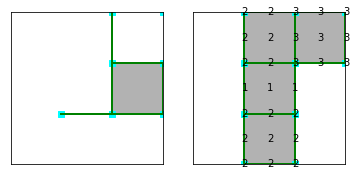

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Setting up the plot
fig, axs = plt.subplots(1, 2, subplot_kw={'xticks': [], 'yticks': []})
axs[0].set_xlim(0, 3)
axs[0].set_ylim(0, 3)
axs[0].set_box_aspect(1)
axs[1].set_xlim(0, 3)
axs[1].set_ylim(0, 3)
axs[1].set_box_aspect(1)

# Plotting 2-dimensional cell
axs[0].add_patch(plt.Rectangle((2, 1), 1, 1, facecolor="black",alpha=0.3))

# Plotting 1-dimensional cells
oneDimCellsX = [[1,2],[2,2],[2,3],[2,3],[2,2],[3,3]]
oneDimCellsY = [[1,1],[1,2],[1,1],[2,2],[2,3],[1,2]]

for i, x in enumerate(oneDimCellsX):
    axs[0].plot(x,oneDimCellsY[i],'g',linewidth=2)
    
# Plotting 0-dimensional cells
axs[0].scatter([1,2,2,2,3,3,3],[1,1,2,3,2,3,1],c='cyan',marker='s')

# Plotting 2-dimensional cells
axs[1].add_patch(plt.Rectangle((1, 1), 1, 1, facecolor="black",alpha=0.3))
axs[1].add_patch(plt.Rectangle((1, 0), 1, 1, facecolor="black",alpha=0.3))
axs[1].add_patch(plt.Rectangle((1, 2), 1, 1, facecolor="black",alpha=0.3))
axs[1].add_patch(plt.Rectangle((2, 2), 1, 1, facecolor="black",alpha=0.3))
axs[1].text(1.45, 2.45, '2')                                                            # plotting the weights
axs[1].text(2.45, 2.45, '3') 
axs[1].text(1.45, 1.45, '1') 
axs[1].text(1.45, 0.45, '2')

# Plotting 1-dimensional cells
oneDimCellsX = [[1,1],[2,2],[1,2],[1,2],[1,2],[1,2],[2,3],[2,3],[3,3]]
oneDimCellsY = [[0,3],[0,3],[0,0],[1,1],[2,2],[3,3],[3,3],[2,2],[2,3]]
for i, x in enumerate(oneDimCellsX):
    axs[1].plot(x,oneDimCellsY[i],'g',linewidth=2)
axs[1].text(0.95, 2.45, '2')                                                            # plotting the weights
axs[1].text(0.95, 1.45, '1')
axs[1].text(0.95, 0.45, '2')
axs[1].text(1.95, 2.45, '3')
axs[1].text(1.95, 1.45, '1')
axs[1].text(1.95, 0.45, '2')
axs[1].text(1.45, 1.95, '2')
axs[1].text(1.45, 2.95, '2')
axs[1].text(1.45, 0.95, '2')
axs[1].text(1.45, -0.05, '2')
axs[1].text(2.45, 1.95, '3')
axs[1].text(2.45, 2.95, '3')
axs[1].text(2.95, 2.45, '3')

# Plotting 0-dimensional cells
axs[1].scatter([1,1,1,1,2,2,2,2,3,3], [0,1,2,3,0,1,2,3,2,3], c='cyan', marker='s')
axs[1].text(0.95, 2.95, '2')                                                            # plotting the weights
axs[1].text(0.95, 1.95, '2')
axs[1].text(0.95, 0.95, '2')
axs[1].text(0.95, -0.05, '2')
axs[1].text(1.95, 2.95, '3')
axs[1].text(1.95, 1.95, '3')
axs[1].text(1.95, 0.95, '2')
axs[1].text(1.95, -0.05, '2')
axs[1].text(2.95, 2.95, '3')
axs[1].text(2.95, 1.95, '3')

plt.show()

As explained in our paper, our implementation of weighted cubical complexes consists in a ```C++``` class ```EmbeddedComplex``` that inherits from the cubical complex class ```Bitmap_cubical_complex``` from the ```GUDHI``` library and additionally stores the embedding coordinates of the vertices in $\mathbb{R}^n$. 
By convention, the embedding coordinates of the vertices in $\mathbb{R}^n$ are evenly spaced and normalized in $[−0.5, 0.5]^n$. 
By default, one top-dimensional cell is associated to each pixel of the image and the values of lower-dimensional cells are equal to the maximum of the values of their cofaces, that is:
$$\varphi(C) = \max_{C'\supset C} \varphi(C').$$

We illustrate the construction of a cubical complex from a 2D digital image below. Consider the following greyscale image:

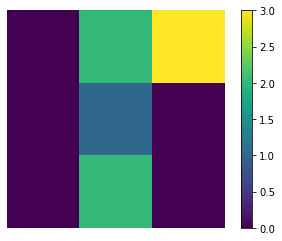

In [43]:
img = np.array([[0,2,0],[0,1,0],[0,2,3]])
plt.imshow(img, origin='lower')
plt.axis('off')
plt.colorbar()
plt.show()

We can turn it into a weighted cubical complex using our ```EmbeddedComplex``` class.

In [142]:
from eucalc import EmbeddedComplex
cplx = eucalc.EmbeddedComplex(img)

Weights of the complex are stored in an array following ```GUDHI```'s convention as detailed in [their documentation](https://gudhi.inria.fr/doc/latest/group__cubical__complex.html). We can print this array:

In [143]:
cplx.print_weights()

AttributeError: 'eucalc.EmbeddedComplex' object has no attribute 'print_weights'

Graphically, the weighted cubical complex looks like:

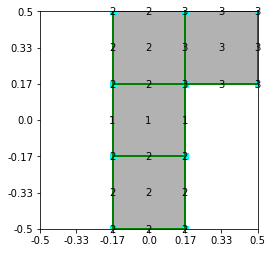

In [138]:
# Setting up the figure
fig, ax = plt.subplots()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_box_aspect(1)
ax.set_xticks(ax.get_xticks()); ax.set_yticks(ax.get_yticks())
ax.set_xticklabels(np.round(np.linspace(-0.5,0.5,7),2))
ax.set_yticklabels(np.round(np.linspace(-0.5,0.5,7),2))

# Plotting top-dimensional cells
ax.add_patch(plt.Rectangle((1, 1), 1, 1, facecolor="black",alpha=0.3))
ax.add_patch(plt.Rectangle((1, 0), 1, 1, facecolor="black",alpha=0.3))
ax.add_patch(plt.Rectangle((1, 2), 1, 1, facecolor="black",alpha=0.3))
ax.add_patch(plt.Rectangle((2, 2), 1, 1, facecolor="black",alpha=0.3))
ax.text(1.45, 2.45, '2')                                                            # plotting the weights
ax.text(2.45, 2.45, '3') 
ax.text(1.45, 1.45, '1') 
ax.text(1.45, 0.45, '2')

# Plotting one-dimensional cells
oneDimCellsX = [[1,1],[2,2],[1,2],[1,2],[1,2],[1,2],[2,3],[2,3],[3,3]]
oneDimCellsY = [[0,3],[0,3],[0,0],[1,1],[2,2],[3,3],[3,3],[2,2],[2,3]]
for i, x in enumerate(oneDimCellsX):
    ax.plot(x,oneDimCellsY[i],'g',linewidth=2)
ax.text(0.95, 2.45, '2')                                                            # plotting the weights
ax.text(0.95, 1.45, '1')
ax.text(0.95, 0.45, '2')
ax.text(1.95, 2.45, '3')
ax.text(1.95, 1.45, '1')
ax.text(1.95, 0.45, '2')
ax.text(1.45, 1.95, '2')
ax.text(1.45, 2.95, '2')
ax.text(1.45, 0.95, '2')
ax.text(1.45, -0.05, '2')
ax.text(2.45, 1.95, '3')
ax.text(2.45, 2.95, '3')
ax.text(2.95, 2.45, '3')

# Plotting zero-dimensional cells
ax.scatter([1,1,1,1,2,2,2,2,3,3], [0,1,2,3,0,1,2,3,2,3], c='cyan', marker='s')
ax.text(0.95, 2.95, '2')                                                            # plotting the weights
ax.text(0.95, 1.95, '2')
ax.text(0.95, 0.95, '2')
ax.text(0.95, -0.05, '2')
ax.text(1.95, 2.95, '3')
ax.text(1.95, 1.95, '3')
ax.text(1.95, 0.95, '2')
ax.text(1.95, -0.05, '2')
ax.text(2.95, 2.95, '3')
ax.text(2.95, 1.95, '3')

plt.show()


## Critical points and critical values

To compute the critical points one need to initalize one of the transforms, for instance lets do it for the ECT. Therefore it gives access to classical critical vertices/values.

In [6]:
# Init ect
cplx.preproc_ect()

Then we chose a direction and compute its index.

In [7]:
direction = [1,1]
index = cplx.get_vector_index(direction)

Then we can print the classical critical vertices and the classical critical values.

In [8]:
verts = cplx.get_classical_critical_vertices(index)
vals = cplx.get_classical_critical_values(index)

verts,vals

([14, 2, 16], [1, 1, -1])

We can have a look at these points using *get_vertex_coordinates* to switch from indexing to coordinates.

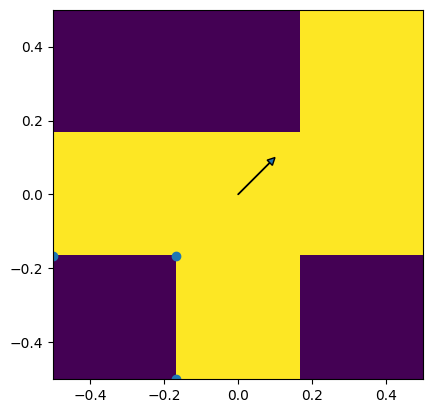

([-0.5, -0.16666666666666666, -0.16666666666666666],
 [-0.16666666666666666, -0.5, -0.16666666666666666])

In [9]:
ptsX,ptsY = [],[]
for v in verts:
    c = cplx.get_coordinates(v)
    ptsX.append(c[0])
    ptsY.append(c[1])

# Plot
plt.imshow(np.flip(img,axis=0),extent=[-0.5,0.5,-0.5,0.5])
plt.arrow(0,0,direction[0]/10,direction[1]/10,length_includes_head=True,head_width=0.02, head_length=0.02)
plt.scatter(ptsX,ptsY)
plt.show()

ptsX,ptsY

In the image above, the chosen direction is represented by an arrow and the critical vertices are the blue dots.